<a href="https://colab.research.google.com/github/dapopadev/dapopadev/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark

# New section





**2.INSTALAMOS EL MÓDULO PYSPARK**



3.**CREAMOS LA SESIÓN PYSPARK***

In [ ]:
from pyspark.sql import SparkSession

In [ ]:
from pyspark.sql.functions import col,sum

In [ ]:
from google.colab import drive

 **DISEÑAMOS UNA UNIDAD PERSONAL DE GOOGLE DRIVE**

In [ ]:
drive.mount("/drive")

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
spark=SparkSession.builder.appName("my_app").getOrCreate()

**3.1.CARGAMOS EL ARCHIVO Air_Traffic_Passenge_Statisitics**

In [ ]:
df=spark.read.option("Header",True).csv("/drive/MyDrive/Air_Traffic_Passenger_Statistics.csv")

In [ ]:
df.show()

+---------------+-----------------+---------------------------+-----------------+---------------------------+-------------+-------------------+------------------+-------------------+-------------+-------------+---------------+---------------------------+------------------------+----+-----+
|Activity Period|Operating Airline|Operating Airline IATA Code|Published Airline|Published Airline IATA Code|  GEO Summary|         GEO Region|Activity Type Code|Price Category Code|     Terminal|Boarding Area|Passenger Count|Adjusted Activity Type Code|Adjusted Passenger Count|Year|Month|
+---------------+-----------------+---------------------------+-----------------+---------------------------+-------------+-------------------+------------------+-------------------+-------------+-------------+---------------+---------------------------+------------------------+----+-----+
|         200507|     ATA Airlines|                         TZ|     ATA Airlines|                         TZ|     Domestic|    

*COPIAMOS EL ARCHIVO Y LE ASIGNAMOS OTRO NOMBRE PARA HACER OTRAS TRANSFORMACIONES MÁS ADELANTE

In [ ]:
df2=df

In [ ]:
df2.show()

+---------------+-----------------+---------------------------+-----------------+---------------------------+-------------+-------------------+------------------+-------------------+-------------+-------------+---------------+---------------------------+------------------------+----+-----+
|Activity Period|Operating Airline|Operating Airline IATA Code|Published Airline|Published Airline IATA Code|  GEO Summary|         GEO Region|Activity Type Code|Price Category Code|     Terminal|Boarding Area|Passenger Count|Adjusted Activity Type Code|Adjusted Passenger Count|Year|Month|
+---------------+-----------------+---------------------------+-----------------+---------------------------+-------------+-------------------+------------------+-------------------+-------------+-------------+---------------+---------------------------+------------------------+----+-----+
|         200507|     ATA Airlines|                         TZ|     ATA Airlines|                         TZ|     Domestic|    

In [ ]:
df.count()

15007

In [ ]:
df1=df.where(col("GEO Region").isNotNull())

In [ ]:
df1.count()

15007

*QUITAMOS ALGUNAS DE LAS COLUMNAS QUE NO NECESITAMOS PARA NUESTRO ANÁLISIS

In [ ]:
df = df.drop("Published Airline IATA Code","Published airline","Activity Type Code","Price Category Code","Terminal","Boarding Area","Adjusted Activity Type Code")


In [ ]:
df.show()

+---------------+-----------------+---------------------------+-------------+-------------------+---------------+------------------------+----+-----+
|Activity Period|Operating Airline|Operating Airline IATA Code|  GEO Summary|         GEO Region|Passenger Count|Adjusted Passenger Count|Year|Month|
+---------------+-----------------+---------------------------+-------------+-------------------+---------------+------------------------+----+-----+
|         200507|     ATA Airlines|                         TZ|     Domestic|                 US|          27271|                   27271|2005| July|
|         200507|     ATA Airlines|                         TZ|     Domestic|                 US|          29131|                   29131|2005| July|
|         200507|     ATA Airlines|                         TZ|     Domestic|                 US|           5415|                   10830|2005| July|
|         200507|      Air Canada |                         AC|International|             Canada|   

In [ ]:
df.dtypes


[('Activity Period', 'string'),
 ('Operating Airline', 'string'),
 ('Operating Airline IATA Code', 'string'),
 ('GEO Summary', 'string'),
 ('GEO Region', 'string'),
 ('Passenger Count', 'string'),
 ('Adjusted Passenger Count', 'string'),
 ('Year', 'string'),
 ('Month', 'string')]

*CONVERTIMOS ALGUNAS COLUMNAS DE TIPO STRING A NÚMERICAS PARA PODER HACER OPERACIONES CON ELLAS

In [ ]:
df=df.withColumn("Year",df["Year"].cast("int"))

In [ ]:
df=df.withColumn("Passenger Count",df["Passenger Count"].cast("int"))

In [ ]:
df=df.withColumn("Adjusted Passenger Count",df["Adjusted Passenger Count"].cast("int"))

In [ ]:
df.printSchema()

root
 |-- Activity Period: string (nullable = true)
 |-- Operating Airline: string (nullable = true)
 |-- Operating Airline IATA Code: string (nullable = true)
 |-- GEO Summary: string (nullable = true)
 |-- GEO Region: string (nullable = true)
 |-- Passenger Count: integer (nullable = true)
 |-- Adjusted Passenger Count: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: string (nullable = true)



**3.2¿CUÁNTAS COMPAÑÍAS DIFERENTES APARECEN EN EL FICHERO?**

In [ ]:
from pyspark.sql import SparkSession

In [ ]:
from pyspark.sql.functions import count_distinct

In [ ]:
spark=SparkSession.builder.appName("DistinctCountExample").getOrCreate()

*EL RESULTADO SEGÚN NUESTRA CONSULTA ES:77 COMPAÑIAS AEREAS

In [ ]:
distinct_companies_count=df.select(count_distinct("Operating Airline")).show()

+---------------------------------+
|count(DISTINCT Operating Airline)|
+---------------------------------+
|                               77|
+---------------------------------+



*TENEMOS 9 REGIONES DIFERENTES DONDE DICHAS COMPAÑIAS OPERAN EN EL MARCO GEO REGION

In [ ]:
df.select("GEO Region").distinct().count()

9

*HE DESCUBIERTO LA FUNCIÓN DESCRIBE QUE ME INDICA UN RESUMEN DE LAS PRINCIPALES OPERACIONES A REALIZAR

In [ ]:
df.describe().show()

+-------+------------------+-----------------+---------------------------+-------------+----------+------------------+------------------------+-----------------+---------+
|summary|   Activity Period|Operating Airline|Operating Airline IATA Code|  GEO Summary|GEO Region|   Passenger Count|Adjusted Passenger Count|             Year|    Month|
+-------+------------------+-----------------+---------------------------+-------------+----------+------------------+------------------------+-----------------+---------+
|  count|             15007|            15007|                      14953|        15007|     15007|             15007|                   15007|            15007|    15007|
|   mean|201045.07336576266|             null|                       null|         null|      null|29240.521090157927|      29331.917105350836|2010.385220230559|     null|
| stddev|313.33619609986414|             null|                       null|         null|      null|58319.509284123524|        58284.18221866

**3.3.¿CUÁNTOS PASAJEROS HAY DE MEDIA LOS VUELOS?**

In [ ]:
from pyspark.sql.functions import sum,count,avg,max

In [ ]:
df.select(avg("Passenger Count")).show()

+--------------------+
|avg(Passenger Count)|
+--------------------+
|  29240.521090157927|
+--------------------+



In [ ]:
df.select(avg("Adjusted Passenger Count")).show()

+-----------------------------+
|avg(Adjusted Passenger Count)|
+-----------------------------+
|           29331.917105350836|
+-----------------------------+



**3.3¿CUÁNTOS PASAJEROS TIENEN DE MEDIA LOS VUELOS DE CADA COMPAÑIA?**

In [ ]:
MediaCompania=df.groupBy("Operating Airline").agg({"Passenger Count":"avg","Adjusted Passenger Count":"avg"})

In [ ]:
MediaCompania.write.mode("overwrite").csv("resultados media compañia.csv",header=True)

*CALCULAMOS LA MEDIA DE PASAJEROS POR REGIÓN

In [ ]:
df.groupBy("GEO Region").agg({"Passenger Count":"avg"}).show()

+-------------------+--------------------+
|         GEO Region|avg(Passenger Count)|
+-------------------+--------------------+
|             Europe|  12755.652465294399|
|    Central America|   4946.715328467153|
|                 US|   58330.34345351044|
|      South America|   2786.011111111111|
|             Mexico|    7173.62062780269|
|        Middle East|    8658.61214953271|
|             Canada|     9777.9682651622|
|Australia / Oceania|   6417.016282225238|
|               Asia|   13435.00458295142|
+-------------------+--------------------+



In [ ]:
MediaRegion=df.groupBy("GEO Region").agg({"Passenger Count":"avg"})

In [ ]:
MediaRegion.write.mode("overwrite").csv("resultados media region.csv",header=True)

*CALCULAMOS LA MEDIA POR COMPANIA AÉREA

In [ ]:
MediaCompania=df.groupBy("Operating Airline").agg({"Passenger Count":"avg"}).show()

+--------------------+--------------------+
|   Operating Airline|avg(Passenger Count)|
+--------------------+--------------------+
|          Icelandair|              2799.7|
|         Ameriflight|                 5.0|
|      Cathay Pacific|  17121.325581395347|
|          Aeromexico|   5463.822222222222|
|      Etihad Airways|   6476.088235294118|
| Philippine Airlines|  10248.635658914729|
|United Airlines -...|   48915.46750232126|
|    Turkish Airlines|   8162.416666666667|
| Swiss International|   6061.640287769784|
|    Independence Air|              6391.3|
|Miami Air Interna...|             107.375|
|          Air France|  11589.077519379845|
|      Japan Airlines|   6470.332046332046|
|    Midwest Airlines|              3883.0|
|      Atlas Air, Inc|                34.0|
|    JetBlue Airways |   35261.13963963964|
|       China Eastern|   5498.402777777777|
|   Mexicana Airlines|   7993.806451612903|
|         Air Canada |  18251.560109289618|
|       Allegiant Air|          

 **3.4 ELIMINAMOS LOS REGISTROS DUPLICADOS POR EL CAMPO "GEO REGION", MANTENIENDO ÚNICAMENTE AQUEL CON MAYOR NÚMERO DE PASAJEROS**

In [ ]:
df.dropDuplicates(["GEO Region"]).select("GEO Region").show()

+-------------------+
|         GEO Region|
+-------------------+
|             Europe|
|    Central America|
|                 US|
|      South America|
|             Mexico|
|        Middle East|
|             Canada|
|Australia / Oceania|
|               Asia|
+-------------------+



In [ ]:
maximo=df.groupBy('GEO Region').agg({"Passenger Count":"max"}).alias("maximo")

*AVERIGUAMOS LA FUNCIÓN"col.COLUMNS" PARA SABER EXACTAMENTE EL NOMBRE DE LA COLUMNA MAXIMO

In [ ]:
maximo.columns

['GEO Region', 'max(Passenger Count)']

In [ ]:
from pyspark.sql.functions import desc

*GUARDAMOS LA COLUMNA CON MAYOR NUMERO DE PASAJEROS ORDENANDO LA CONSULTA DE MAYOR A MENOR LIMITANDOLA A 1 PARA GUARDARLA EN UN NUEVO CSV

In [ ]:
maximo.orderBy(desc("max(Passenger Count)")).limit(1).write.mode("overwrite").csv("maximo pasajeros por region.csv",header=True)

*OTRA FORMA DE ELIMINAR DUPLICADOS

In [ ]:
dropDisDF=df.dropDuplicates(["GEO Region"])

In [ ]:
df.dropDuplicates().show()

+---------------+--------------------+---------------------------+-------------+----------+---------------+------------------------+----+---------+
|Activity Period|   Operating Airline|Operating Airline IATA Code|  GEO Summary|GEO Region|Passenger Count|Adjusted Passenger Count|Year|    Month|
+---------------+--------------------+---------------------------+-------------+----------+---------------+------------------------+----+---------+
|         200508|        ATA Airlines|                         TZ|     Domestic|        US|          26535|                   26535|2005|   August|
|         200508|        ATA Airlines|                         TZ|     Domestic|        US|           5712|                   11424|2005|   August|
|         200510|United Airlines -...|                         UA|International|    Europe|          27617|                   27617|2005|  October|
|         200512|    SkyWest Airlines|                         OO|     Domestic|        US|          90500|     

In [ ]:
print("Distinct count of GEO Region:"+str(dropDisDF.count()))

Distinct count of GEO Region:9


In [ ]:
distinctDF=df.distinct()

In [ ]:
print("Distinct count:"+str(distinctDF.count()))

Distinct count:14975


In [ ]:
distinctDF.show(truncate=False)

+---------------+--------------------------------+---------------------------+-------------+----------+---------------+------------------------+----+---------+
|Activity Period|Operating Airline               |Operating Airline IATA Code|GEO Summary  |GEO Region|Passenger Count|Adjusted Passenger Count|Year|Month    |
+---------------+--------------------------------+---------------------------+-------------+----------+---------------+------------------------+----+---------+
|200508         |ATA Airlines                    |TZ                         |Domestic     |US        |26535          |26535                   |2005|August   |
|200508         |ATA Airlines                    |TZ                         |Domestic     |US        |5712           |11424                   |2005|August   |
|200510         |United Airlines - Pre 07/01/2013|UA                         |International|Europe    |27617          |27617                   |2005|October  |
|200512         |SkyWest Airlines       

**4. ANÁLISIS DESCRIPTIVO DE LOS DATOS**

*VISUALIZAMOS LOS DIFERENTES TIPOS DE DATOS POR SI NECESITAMOS HACER MÁS CAMBIOS DE TIPO DE DATO

In [ ]:
df.printSchema()

root
 |-- Activity Period: string (nullable = true)
 |-- Operating Airline: string (nullable = true)
 |-- Operating Airline IATA Code: string (nullable = true)
 |-- GEO Summary: string (nullable = true)
 |-- GEO Region: string (nullable = true)
 |-- Passenger Count: integer (nullable = true)
 |-- Adjusted Passenger Count: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: string (nullable = true)



**CALCULAR LA MEDIA EN FUNCIÓN DE LOS DIFERENTES CAMPOS**

In [ ]:
from pyspark.sql import SparkSession

In [ ]:
from pyspark.sql import functions as F

In [ ]:
from pyspark.sql.functions import count,sum,avg,round,mean,asc

In [ ]:
mediaYear=df.groupBy("Year").agg({"Passenger Count":"mean","Adjusted Passenger Count":"mean"}).alias("Year")

In [ ]:
mediaYear.columns

['Year', 'avg(Passenger Count)', 'avg(Adjusted Passenger Count)']

In [ ]:
mediaYear.orderBy(asc("Year")).show()

+----+--------------------+-----------------------------+
|Year|avg(Passenger Count)|avg(Adjusted Passenger Count)|
+----+--------------------+-----------------------------+
|2005|  24779.903597122302|           25002.343884892085|
|2006|  24348.407596785975|            24529.88458728999|
|2007|   25233.55713271824|           25401.585521646557|
|2008|   25983.72505233775|           26100.866015352407|
|2009|  26804.696338837042|            26887.03086862886|
|2010|  28383.224150397687|           28482.454085321766|
|2011|   29444.45035971223|            29529.08705035971|
|2012|  32220.526124818578|           32276.639332365747|
|2013|   33097.02503681885|            33145.62886597938|
|2014|   34440.51973684211|           34470.102339181285|
|2015|   34286.22397260274|             34292.5301369863|
|2016|  30808.212938005392|           30811.854447439353|
+----+--------------------+-----------------------------+



*EL AÑO QUE MÁS PASAJEROS POR VUELOS HUBO FUE 2016. PODEMOS OBSERVAR QUE CADA AÑO LA TENDENCIA ES ASCENDENTE CON RESPETO AL ANTERIOR

In [ ]:
mediaCompania=df.groupBy("Operating Airline").agg({"Passenger Count":"mean","Adjusted Passenger Count":"mean"}).alias("media Compania")

In [ ]:
mediaCompania.orderBy(desc("avg(Passenger Count)")).show()

+--------------------+--------------------+-----------------------------+
|   Operating Airline|avg(Passenger Count)|avg(Adjusted Passenger Count)|
+--------------------+--------------------+-----------------------------+
|   American Airlines|  127164.38970588235|           127164.38970588235|
|  Southwest Airlines|   81188.15857605178|             81223.3495145631|
|      Virgin America|   74405.35359116022|            74405.35359116022|
|     United Airlines|   72732.05829596413|            72827.21973094171|
|     Delta Air Lines|   68498.49740932643|            68515.41968911917|
|          US Airways|   55317.81578947369|            55317.81578947369|
|United Airlines -...|   48915.46750232126|            49365.51671309192|
|    SkyWest Airlines|   37083.83904465213|             37083.8764278297|
|    JetBlue Airways |   35261.13963963964|            35261.13963963964|
|  Northwest Airlines|            26109.25|           26205.504166666666|
|    Compass Airlines|   23358.5568181

In [ ]:
mediaCompania.orderBy(asc("avg(Passenger Count)")).show()

+--------------------+--------------------+-----------------------------+
|   Operating Airline|avg(Passenger Count)|avg(Adjusted Passenger Count)|
+--------------------+--------------------+-----------------------------+
|Evergreen Interna...|                 2.0|                          2.0|
|         Ameriflight|                 5.0|            5.363636363636363|
|      Boeing Company|                18.0|                         18.0|
|      Atlas Air, Inc|                34.0|                         35.5|
|        Xtra Airways|                73.0|                         73.0|
|           Servisair|   90.05555555555556|            90.05555555555556|
|Miami Air Interna...|             107.375|                      107.375|
|    Pacific Aviation|               160.0|                        160.0|
|       Swissport USA|               258.6|                        264.8|
|       World Airways|   261.6666666666667|            261.6666666666667|
|     Air Canada Jazz|   294.214285714

* CON REFERENCIA A LAS COMPANIAS QUE MÁS VUELOS HAN REALIZADO SE ENCUENTRA EN LA CABEZA AMERICAN AIRLINES CON 127.164 PASAJEROS SEGUIDA DE LEJOS DE SOUTHWEST AIRLINES CON 81188 PASAJEROS Y LAS QUE MENOS VUELOS HAN REALIZADO HAN SIDO EVERGREEN INTERNATIONAL CON 2 PASAJEROS?¿?? Y AMERICAN FLIGHT CON 5 PASAJEROS?¿?¿?  

In [ ]:
mediaRegion=df.groupBy("GEO REgion").agg({"Passenger Count":"mean","Adjusted Passenger Count":"mean"}).alias("media Region")

In [ ]:
mediaRegion.orderBy(desc("avg(Passenger Count)")).show()

+-------------------+--------------------+-----------------------------+
|         GEO REgion|avg(Passenger Count)|avg(Adjusted Passenger Count)|
+-------------------+--------------------+-----------------------------+
|                 US|   58330.34345351044|            58485.87838537175|
|               Asia|   13435.00458295142|           13508.552703941337|
|             Europe|  12755.652465294399|           12779.055050263283|
|             Canada|     9777.9682651622|             9803.79125528914|
|        Middle East|    8658.61214953271|             8658.61214953271|
|             Mexico|    7173.62062780269|            7250.898654708521|
|Australia / Oceania|   6417.016282225238|            6495.104477611941|
|    Central America|   4946.715328467153|            4946.715328467153|
|      South America|   2786.011111111111|            2786.011111111111|
+-------------------+--------------------+-----------------------------+



*LA REGIÓN QUE MÁS VUELOS DE MEDIA REALIZA ES US Y LA QUE MENOS SOUTH AMERICA

In [ ]:
mediaTipo=df.groupBy("GEO Summary").agg({"Passenger Count":"mean","Adjusted Passenger Count":"mean"}).alias("media Tipo")

In [ ]:
mediaTipo.orderBy(asc("avg(Passenger Count)")).show()

+-------------+--------------------+-----------------------------+
|  GEO Summary|avg(Passenger Count)|avg(Adjusted Passenger Count)|
+-------------+--------------------+-----------------------------+
|International|  10930.673072747015|           10981.698479913139|
|     Domestic|   58330.34345351044|            58485.87838537175|
+-------------+--------------------+-----------------------------+



*SEGÚN ESTA CONSULTA EN CONCRETO LA MEDIA DE LOS VUELOS INTERNACIONALES DOBLAN A LOS VUELOS NACIONALES

***LA FORMULA DE LA MEDIA TOMANDO EN CUENTA SOLAMENTE EL CAMPO QUE NOS INTERESA***

In [ ]:
df.agg({'Passenger Count':'mean'}).show()

+--------------------+
|avg(Passenger Count)|
+--------------------+
|  29240.521090157927|
+--------------------+



In [ ]:
df.agg({'Adjusted Passenger Count':'mean'}).show()

+-----------------------------+
|avg(Adjusted Passenger Count)|
+-----------------------------+
|           29331.917105350836|
+-----------------------------+



*CALCULAMOS EL MÁXIMO Y EL MINIMO DE NÚMERO DE PASAJEROS QUE HEMOS AGRUPADO ANTERIORMENTE

In [ ]:
df.agg({'Adjusted Passenger Count':'max'}).show()

+-----------------------------+
|max(Adjusted Passenger Count)|
+-----------------------------+
|                       659837|
+-----------------------------+



In [ ]:
df.agg({'Passenger Count':'max'}).show()

+--------------------+
|max(Passenger Count)|
+--------------------+
|              659837|
+--------------------+



In [ ]:
df.agg({'Passenger Count':'min'}).show()

+--------------------+
|min(Passenger Count)|
+--------------------+
|                   1|
+--------------------+



In [ ]:
df.agg({'Adjusted Passenger Count':'min'}).show()

+-----------------------------+
|min(Adjusted Passenger Count)|
+-----------------------------+
|                            1|
+-----------------------------+



***4.1 CALCULAMOS LA DESVIACIÓN ESTÁNDAR EN FUNCIÓN DE LAS DIFERENTES COLUMNAS***

In [ ]:
desviacionRegion=df.groupBy("GEO Region").agg({"Passenger Count":"std","Adjusted Passenger Count":"std"}).alias("desviacion Region")

In [ ]:
desviacionRegion.columns

['GEO Region', 'stddev(Passenger Count)', 'stddev(Adjusted Passenger Count)']

In [ ]:
desviacionRegion.orderBy(desc("stddev(Passenger Count)")).show()

+-------------------+-----------------------+--------------------------------+
|         GEO Region|stddev(Passenger Count)|stddev(Adjusted Passenger Count)|
+-------------------+-----------------------+--------------------------------+
|                 US|      84951.31664013123|               84859.99154024843|
|               Asia|     16188.148775860833|              16147.810666731062|
|             Europe|      8634.076411562175|                8602.12804355499|
|             Canada|      7833.110588404248|               7805.730643538237|
|             Mexico|      5336.223001980255|               5274.346847133504|
|Australia / Oceania|     2799.8406500183883|               2650.383265187285|
|        Middle East|        2732.7195183986|                 2732.7195183986|
|    Central America|     1220.8403125914656|              1220.8403125914656|
|      South America|      396.7586506195526|               396.7586506195526|
+-------------------+-----------------------+-------

*LA MAYOR DESVIACIÓN SEGÚN LA REGIÓN LA TIENE US Y LA QUE MENOS SOUTH AMERICA

In [ ]:
desviacionCompania=df.groupBy("Operating Airline").agg({"passenger Count":"std","Adjusted Passenger Count":"std"}).alias("desviacion Compania")

In [ ]:
desviacionCompania.orderBy(desc("stddev(Passenger Count)")).show()

+--------------------+-----------------------+--------------------------------+
|   Operating Airline|stddev(passenger Count)|stddev(Adjusted Passenger Count)|
+--------------------+-----------------------+--------------------------------+
|     United Airlines|      111407.6096590275|              111353.44506100845|
|United Airlines -...|     101345.43251928187|              101159.04786282202|
|      Virgin America|      68539.60912970702|               68539.60912970702|
|  Southwest Airlines|      60358.22460648464|              60310.953620260676|
|     Delta Air Lines|     52441.708028502915|              52420.016941335474|
|    SkyWest Airlines|     47114.391824800696|               47114.36241270175|
|  Northwest Airlines|      23299.20468096906|              23201.110752157398|
|   American Airlines|     22044.236526572004|              22044.236526572004|
|          US Airways|     17368.956304696872|              17368.956304696872|
|     Alaska Airlines|     16964.7196589

In [ ]:
desviacionCompania.orderBy(asc("stddev(Passenger Count)")).show()

+--------------------+-----------------------+--------------------------------+
|   Operating Airline|stddev(passenger Count)|stddev(Adjusted Passenger Count)|
+--------------------+-----------------------+--------------------------------+
|      Boeing Company|                   null|                            null|
|Evergreen Interna...|                    0.0|                             0.0|
|    Pacific Aviation|                    0.0|                             0.0|
|        Xtra Airways|                    0.0|                             0.0|
|         Ameriflight|      2.811540841738193|               3.619332410758523|
|       World Airways|       8.32666399786453|                8.32666399786453|
|      Atlas Air, Inc|     43.840620433565945|               41.71930009000631|
|Miami Air Interna...|     57.147615873280316|              57.147615873280316|
|           Servisair|      58.46461417910078|               58.46461417910078|
|       Swissport USA|     108.631618654

*LA MAYOR DESVIACIÓN EN FUNCIÓN DE CADA COMPAÑIA ES LA DE UNITED AIRLINES Y LA QUE MENOS ES LA DE AMERICAN FLIGHT

In [ ]:
desviacionTipo=df.groupBy("GEO Summary").agg({"Passenger Count":"std","Adjusted Passenger Count":"std"}).alias("desviacion Tipo")

In [ ]:
desviacionTipo.orderBy(asc("stddev(Passenger Count)")).show()

+-------------+-----------------------+--------------------------------+
|  GEO Summary|stddev(Passenger Count)|stddev(Adjusted Passenger Count)|
+-------------+-----------------------+--------------------------------+
|International|     11493.706383971215|              11459.569919328736|
|     Domestic|      84951.31664013123|               84859.99154024843|
+-------------+-----------------------+--------------------------------+



In [ ]:
desviacionYear=df.groupBy("Year").agg({"Passenger Count":"std","Adjusted Passenger Count":"std"}).alias("deviacion Year")

In [ ]:
desviacionYear.orderBy(asc("stddev(Passenger Count)")).show()

+----+-----------------------+--------------------------------+
|Year|stddev(Passenger Count)|stddev(Adjusted Passenger Count)|
+----+-----------------------+--------------------------------+
|2008|       50774.2273603889|               50726.95614634388|
|2007|     52686.333022728555|               52626.74622716829|
|2006|      53418.13826968551|               53358.71428377348|
|2005|      54774.38414321783|               54707.74430644306|
|2009|      55096.04274953367|               55063.05908647803|
|2016|     56351.917740411474|               56349.96176502073|
|2010|       57782.3443543718|               57745.14106412592|
|2011|     57938.886803724185|               57905.04645191029|
|2012|     58612.368565066805|                58587.4853792429|
|2015|     62735.130892386165|               62731.74505650158|
|2014|      63694.36786274649|               63681.87984916423|
|2013|      69500.20489950952|               69484.16000796498|
+----+-----------------------+----------

LA MENOR DESVIACIÓN TOMANDO EN CONSIDERACIÓN EL AÑO ES 2008 Y LA QUE MÁS 2013

*LA FORMULA DE LA DESVIACIÓN EN FUNCIÓN DE CADA CAMPO EN CONCRETO

In [ ]:
df.agg({'Passenger count':'std'}).show()

+-----------------------+
|stddev(Passenger count)|
+-----------------------+
|     58319.509284123524|
+-----------------------+



In [ ]:
df.agg({'Adjusted Passenger count':'std'}).show()

+--------------------------------+
|stddev(Adjusted Passenger count)|
+--------------------------------+
|                58284.1822186625|
+--------------------------------+



**4.2 ANÁLISIS DE CORRELACIÓN**

In [ ]:
df.printSchema()

root
 |-- Activity Period: string (nullable = true)
 |-- Operating Airline: string (nullable = true)
 |-- Operating Airline IATA Code: string (nullable = true)
 |-- GEO Summary: string (nullable = true)
 |-- GEO Region: string (nullable = true)
 |-- Passenger Count: integer (nullable = true)
 |-- Adjusted Passenger Count: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: string (nullable = true)



In [ ]:
df.show(6)

+---------------+-----------------+---------------------------+-------------+----------+---------------+------------------------+----+-----+
|Activity Period|Operating Airline|Operating Airline IATA Code|  GEO Summary|GEO Region|Passenger Count|Adjusted Passenger Count|Year|Month|
+---------------+-----------------+---------------------------+-------------+----------+---------------+------------------------+----+-----+
|         200507|     ATA Airlines|                         TZ|     Domestic|        US|          27271|                   27271|2005| July|
|         200507|     ATA Airlines|                         TZ|     Domestic|        US|          29131|                   29131|2005| July|
|         200507|     ATA Airlines|                         TZ|     Domestic|        US|           5415|                   10830|2005| July|
|         200507|      Air Canada |                         AC|International|    Canada|          35156|                   35156|2005| July|
|         200

In [ ]:
no_str_df=df.drop("Activity Period","Operating Airline","Operating Airline IATA Code","GEO Summary","GEO Region","Month")

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

In [ ]:
vector_col="corr_vars"

In [ ]:
assembler=VectorAssembler(inputCols=no_str_df.columns,outputCol=vector_col)

In [ ]:
no_str_df.columns

['Passenger Count', 'Adjusted Passenger Count', 'Year']

In [ ]:
no_str_df.show()

+---------------+------------------------+----+
|Passenger Count|Adjusted Passenger Count|Year|
+---------------+------------------------+----+
|          27271|                   27271|2005|
|          29131|                   29131|2005|
|           5415|                   10830|2005|
|          35156|                   35156|2005|
|          34090|                   34090|2005|
|           6263|                    6263|2005|
|           5500|                    5500|2005|
|          12050|                   12050|2005|
|          11638|                   11638|2005|
|           4998|                    4998|2005|
|           4962|                    4962|2005|
|           8055|                    8055|2005|
|           7984|                    7984|2005|
|          36641|                   36641|2005|
|          39379|                   39379|2005|
|           3678|                    7356|2005|
|           7977|                    7977|2005|
|           8837|                    883

In [ ]:
no_str_df.printSchema()

root
 |-- Passenger Count: integer (nullable = true)
 |-- Adjusted Passenger Count: integer (nullable = true)
 |-- Year: integer (nullable = true)



In [ ]:
df_vector=assembler.transform(no_str_df).select(vector_col)

In [ ]:
corr_matrix=Correlation.corr(df_vector,vector_col).collect()[0][0].toArray().tolist()

In [ ]:
corr_matrix_df=spark.createDataFrame(corr_matrix,no_str_df.columns)

In [ ]:
corr_matrix_df.show()

+-------------------+------------------------+--------------------+
|    Passenger Count|Adjusted Passenger Count|                Year|
+-------------------+------------------------+--------------------+
|                1.0|      0.9999408877427237| 0.06006904043285836|
| 0.9999408877427237|                     1.0|0.059096234917787455|
|0.06006904043285836|    0.059096234917787455|                 1.0|
+-------------------+------------------------+--------------------+



REALIZAMOS UNA CORRELACIÓN DE LAS COLUMNAS NÚMERICAS.HAY UNA CORRELACIÓN POSITIVA ENTRE EL CAMPO AÑO Y EL CAMPO DEL Nº DE PASAJEROS/Nº DE PASAJEROS AJUSTADO

INTENTAMOS CORRELACIONAR LOS CAMPOS CATEGORICOS AHORA PARA VER DE QUE MANERA ESTÁN CORRELACIONADOS.
VOLVEMOS A CARGAR EL DATAFRAME ORIGINAL CON TODAS SUS COLUMNAS

In [ ]:
df2.show()

+---------------+-----------------+---------------------------+-----------------+---------------------------+-------------+-------------------+------------------+-------------------+-------------+-------------+---------------+---------------------------+------------------------+----+-----+
|Activity Period|Operating Airline|Operating Airline IATA Code|Published Airline|Published Airline IATA Code|  GEO Summary|         GEO Region|Activity Type Code|Price Category Code|     Terminal|Boarding Area|Passenger Count|Adjusted Activity Type Code|Adjusted Passenger Count|Year|Month|
+---------------+-----------------+---------------------------+-----------------+---------------------------+-------------+-------------------+------------------+-------------------+-------------+-------------+---------------+---------------------------+------------------------+----+-----+
|         200507|     ATA Airlines|                         TZ|     ATA Airlines|                         TZ|     Domestic|    

CRUZAMOS 2 CAMPOS CATEGORICOS:LA CATEGORIA DEL PRECIO Y EL TIPO DE ACTIVIDAD

In [ ]:
df2.crosstab("Price Category Code","Activity Type code").show()

+--------------------------------------+--------+--------+--------------+
|Price Category Code_Activity Type code|Deplaned|Enplaned|Thru / Transit|
+--------------------------------------+--------+--------+--------------+
|                                 Other|    6168|    6112|           807|
|                              Low Fare|     903|     904|           113|
+--------------------------------------+--------+--------+--------------+



In [ ]:
df2.crosstab("GEO Summary","GEO Region").show()

+----------------------+----+-------------------+------+---------------+------+------+-----------+-------------+----+
|GEO Summary_GEO Region|Asia|Australia / Oceania|Canada|Central America|Europe|Mexico|Middle East|South America|  US|
+----------------------+----+-------------------+------+---------------+------+------+-----------+-------------+----+
|         International|3273|                737|  1418|            274|  2089|  1115|        214|           90|   0|
|              Domestic|   0|                  0|     0|              0|     0|     0|          0|            0|5797|
+----------------------+----+-------------------+------+---------------+------+------+-----------+-------------+----+



In [ ]:
df2.crosstab("GEO Region","Price Category Code").show()

+------------------------------+--------+-----+
|GEO Region_Price Category Code|Low Fare|Other|
+------------------------------+--------+-----+
|                        Europe|       2| 2087|
|               Central America|       0|  274|
|                            US|    1746| 4051|
|                 South America|       0|   90|
|                        Mexico|     140|  975|
|                   Middle East|       2|  212|
|                        Canada|      26| 1392|
|           Australia / Oceania|       2|  735|
|                          Asia|       2| 3271|
+------------------------------+--------+-----+



HACEMOS LA MATRÍZ DE CORRELACIÓN ENTRE PASSENGR COUNT/ADJUSTED PASSENGER COUNT Y EL AÑO Y VEMOS QUE NO HAY CASI CORRELACIÓN. eSTÁ PROXIMA A LA NULA 0.06 LO QUE NOS INDICA UE NO TIENEN UNA INFLUENCIA UNA SOBRE LA OTRA

In [ ]:
plot_corr=corr_matrix_df.toPandas()
plot_corr.index=corr_matrix_df.columns
plot_corr.style.background_gradient(cmap='Blues')

,Passenger Count,Adjusted Passenger Count,Year
Passenger Count,1.000000,0.999941,0.060069
Adjusted Passenger Count,0.999941,1.000000,0.059096
Year,0.060069,0.059096,1.000000


In [ ]:
corr_matrix_s=Correlation.corr(df_vector,vector_col,"spearman").collect()[0][0].toArray().tolist()

In [ ]:
corr_matrix_s_df=spark.createDataFrame(corr_matrix_s,no_str_df.columns)

In [ ]:
corr_matrix_s_df.show()

+-------------------+------------------------+-------------------+
|    Passenger Count|Adjusted Passenger Count|               Year|
+-------------------+------------------------+-------------------+
|                1.0|      0.9946303895085199|0.06538464949207762|
| 0.9946303895085199|                     1.0|0.05661651859812159|
|0.06538464949207762|     0.05661651859812159|                1.0|
+-------------------+------------------------+-------------------+



In [ ]:
plot_corr_s=corr_matrix_s_df.toPandas()

In [ ]:
plot_corr_s.index=corr_matrix_s_df.columns

In [ ]:
plot_corr_s.style.background_gradient(cmap='Reds')

,Passenger Count,Adjusted Passenger Count,Year
Passenger Count,1.000000,0.994630,0.065385
Adjusted Passenger Count,0.994630,1.000000,0.056617
Year,0.065385,0.056617,1.000000


***ANÁLISIS DEL ALGORITMO DE KMEANS***

In [ ]:
from pyspark.sql import SparkSession

In [ ]:
spark=SparkSession.builder.appName("my_app").getOrCreate()

In [ ]:
df=spark.read.csv("/drive/MyDrive/Air_Traffic_Passenger_Statistics.csv",header=True,inferSchema=True)

In [ ]:
df.printSchema()

root
 |-- Activity Period: integer (nullable = true)
 |-- Operating Airline: string (nullable = true)
 |-- Operating Airline IATA Code: string (nullable = true)
 |-- Published Airline: string (nullable = true)
 |-- Published Airline IATA Code: string (nullable = true)
 |-- GEO Summary: string (nullable = true)
 |-- GEO Region: string (nullable = true)
 |-- Activity Type Code: string (nullable = true)
 |-- Price Category Code: string (nullable = true)
 |-- Terminal: string (nullable = true)
 |-- Boarding Area: string (nullable = true)
 |-- Passenger Count: integer (nullable = true)
 |-- Adjusted Activity Type Code: string (nullable = true)
 |-- Adjusted Passenger Count: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: string (nullable = true)



In [ ]:
df.show(5)

+---------------+-----------------+---------------------------+-----------------+---------------------------+-------------+----------+------------------+-------------------+----------+-------------+---------------+---------------------------+------------------------+----+-----+
|Activity Period|Operating Airline|Operating Airline IATA Code|Published Airline|Published Airline IATA Code|  GEO Summary|GEO Region|Activity Type Code|Price Category Code|  Terminal|Boarding Area|Passenger Count|Adjusted Activity Type Code|Adjusted Passenger Count|Year|Month|
+---------------+-----------------+---------------------------+-----------------+---------------------------+-------------+----------+------------------+-------------------+----------+-------------+---------------+---------------------------+------------------------+----+-----+
|         200507|     ATA Airlines|                         TZ|     ATA Airlines|                         TZ|     Domestic|        US|          Deplaned|          

In [ ]:
df.describe().toPandas()

,summary,Activity Period,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Activity Type Code,Price Category Code,Terminal,Boarding Area,Passenger Count,Adjusted Activity Type Code,Adjusted Passenger Count,Year,Month
0,count,15007,15007,14953,15007,14953,15007,15007,15007,15007,15007,15007,15007,15007,15007,15007,15007
1,mean,201045.07336576266,None,None,None,None,None,None,None,None,None,None,29240.521090157927,None,29331.917105350836,2010.385220230559,None
2,stddev,313.33619609986414,None,None,None,None,None,None,None,None,None,None,58319.509284123524,None,58284.1822186625,3.137589043169972,None
3,min,200507,ATA Airlines,4T,ATA Airlines,4T,Domestic,Asia,Deplaned,Low Fare,International,A,1,Deplaned,1,2005,April
4,max,201603,Xtra Airways,YX,Xtra Airways,YX,International,US,Thru / Transit,Other,Terminal 3,Other,659837,Thru / Transit * 2,659837,2016,September


In [ ]:
from pyspark.ml.linalg import Vectors

In [ ]:
from pyspark.ml.feature import VectorAssembler

In [ ]:
df.columns

['Activity Period',
 'Operating Airline',
 'Operating Airline IATA Code',
 'Published Airline',
 'Published Airline IATA Code',
 'GEO Summary',
 'GEO Region',
 'Activity Type Code',
 'Price Category Code',
 'Terminal',
 'Boarding Area',
 'Passenger Count',
 'Adjusted Activity Type Code',
 'Adjusted Passenger Count',
 'Year',
 'Month']

CREAMOS LA COLUMNA FEAT_COLS

In [ ]:
feat_cols=['Activity Period',
'Passenger Count',
'Adjusted Passenger Count',
'Year']

In [ ]:
assembler=VectorAssembler(inputCols=feat_cols,outputCol='features')

In [ ]:
final_df=assembler.transform(df)

In [ ]:
final_df.select("features").show(5)

+--------------------+
|            features|
+--------------------+
|[200507.0,27271.0...|
|[200507.0,29131.0...|
|[200507.0,5415.0,...|
|[200507.0,35156.0...|
|[200507.0,34090.0...|
+--------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.feature import StandardScaler

In [ ]:
scaler=StandardScaler(inputCol='features',
                      outputCol='scaled_feat',
                      withStd=True,
                      withMean=False)

In [ ]:
scaled_model=scaler.fit(final_df)

In [ ]:
cluster_df=scaled_model.transform(final_df)

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [ ]:
evaluator=ClusteringEvaluator(predictionCol="prediction",
                         featuresCol="features",
                         metricName="silhouette",
                         distanceMeasure="squaredEuclidean")

In [ ]:
silhouette_score=[]
for i in range(2,10):
  kmeans=KMeans(featuresCol='features',k=i)
  model=kmeans.fit(final_df)
  predictions=model.transform(final_df)
  score=evaluator.evaluate(predictions)
  silhouette_score.append(score)
  print('Silhouette Score for k=',i,'is',score)

Silhouette Score for k= 2 is 0.9647493098057984
Silhouette Score for k= 3 is 0.9176042673190565
Silhouette Score for k= 4 is 0.9005890490985067
Silhouette Score for k= 5 is 0.9016522671775614
Silhouette Score for k= 6 is 0.8060801744342979
Silhouette Score for k= 7 is 0.8567961856374088
Silhouette Score for k= 8 is 0.7968349281014988
Silhouette Score for k= 9 is 0.7778264481757934


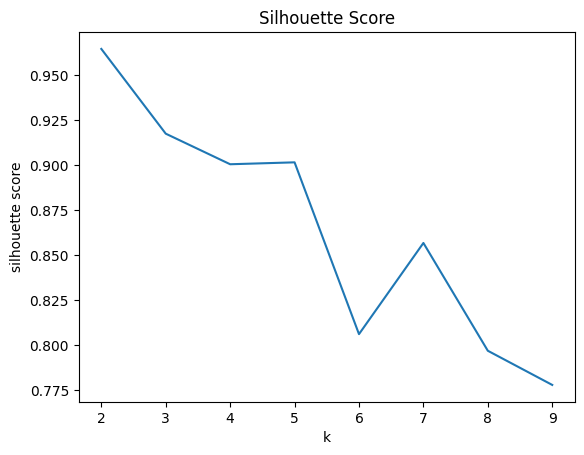

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(2,10),silhouette_score)
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.title('Silhouette Score')
plt.show()

***ENTRENAR EL MODELO***

In [ ]:
kmeans=KMeans(featuresCol='features',k=6)
model=kmeans.fit(final_df)
predictions=model.transform(final_df)

In [ ]:
centers=model.clusterCenters()
print('cluster Centers')
for center in centers:
  print (center)

cluster Centers
[201038.82030192   6946.08196245   7075.07538223   2010.32301142]
[200983.89130435 394207.8423913  394207.8423913    2009.76630435]
[201169.15466352 134378.10035419 134378.10035419   2011.62455726]
[201300.50724638 278092.77536232 278092.77536232   2012.94927536]
[201043.71957447  26924.45361702  26940.86297872   2010.37106383]
[200991.96360485  68483.47140381  68483.47140381   2009.85355286]


***ENTRENAR EL MODELO***

In [ ]:
kmeans=KMeans(featuresCol='features',k=7)
model=kmeans.fit(final_df)
predictions=model.transform(final_df)

In [ ]:
centers=model.clusterCenters()
print("Cluster Centers:")
for center in centers:
  print(centers)

Cluster Centers:
[array([201041.38588092,   8209.80736421,   8327.84279248,   2010.3485376 ]), array([200965.84745763, 378471.16384181, 378471.16384181,   2009.58757062]), array([201322.57142857, 561231.85714286, 561231.85714286,   2013.14285714]), array([200997.99582027,  75313.20376176,  75313.20376176,   2009.91431557]), array([201013.08035714,  37234.4581044 ,  37245.16483516,   2010.06524725]), array([201185.38520408, 136861.07142857, 136861.07142857,   2011.78571429]), array([201305.61068702, 275300.79389313, 275300.79389313,   2013.        ])]
[array([201041.38588092,   8209.80736421,   8327.84279248,   2010.3485376 ]), array([200965.84745763, 378471.16384181, 378471.16384181,   2009.58757062]), array([201322.57142857, 561231.85714286, 561231.85714286,   2013.14285714]), array([200997.99582027,  75313.20376176,  75313.20376176,   2009.91431557]), array([201013.08035714,  37234.4581044 ,  37245.16483516,   2010.06524725]), array([201185.38520408, 136861.07142857, 136861.07142857,

In [ ]:
predictions.select('prediction').show(5)

+----------+
|prediction|
+----------+
|         4|
|         4|
|         0|
|         4|
|         4|
+----------+
only showing top 5 rows



In [ ]:
from pyspark.ml.clustering import KMeans

In [ ]:
kmeans=KMeans(k=7)

In [ ]:
model=kmeans.fit(final_df.select('features'))

In [ ]:
transformed=model.transform(final_df)

In [ ]:
from pyspark.ml.clustering import BisectingKMeans

In [ ]:
bkm=BisectingKMeans().setK(7).setSeed(1)

In [ ]:
model=bkm.fit(final_df)

In [ ]:
predictions=model.transform(final_df)

In [ ]:
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt

In [ ]:
df=pd.read_csv("/drive/MyDrive/Air_Traffic_Passenger_Statistics.csv")

In [ ]:
df.head()

,Activity Period,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Activity Type Code,Price Category Code,Terminal,Boarding Area,Passenger Count,Adjusted Activity Type Code,Adjusted Passenger Count,Year,Month
0,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Deplaned,Low Fare,Terminal 1,B,27271,Deplaned,27271,2005,July
1,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Enplaned,Low Fare,Terminal 1,B,29131,Enplaned,29131,2005,July
2,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Thru / Transit,Low Fare,Terminal 1,B,5415,Thru / Transit * 2,10830,2005,July
3,200507,Air Canada,AC,Air Canada,AC,International,Canada,Deplaned,Other,Terminal 1,B,35156,Deplaned,35156,2005,July
4,200507,Air Canada,AC,Air Canada,AC,International,Canada,Enplaned,Other,Terminal 1,B,34090,Enplaned,34090,2005,July


Text(0, 0.5, 'Passenger Count(5)')

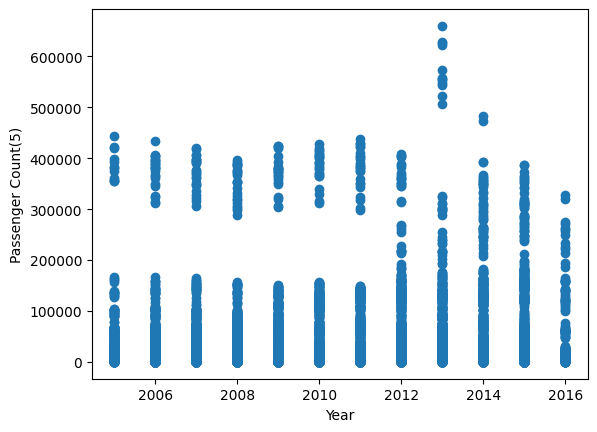

In [ ]:
plt.scatter(df.Year,df['Passenger Count'])
plt.xlabel('Year')
plt.ylabel('Passenger Count(5)')

In [ ]:
km=KMeans(n_clusters=3)
y_predicted=km.fit_predict(df[['Year','Passenger Count']])
y_predicted

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [ ]:
df['cluster']=y_predicted
df.head()

,Activity Period,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Activity Type Code,Price Category Code,Terminal,Boarding Area,Passenger Count,Adjusted Activity Type Code,Adjusted Passenger Count,Year,Month,cluster
0,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Deplaned,Low Fare,Terminal 1,B,27271,Deplaned,27271,2005,July,0
1,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Enplaned,Low Fare,Terminal 1,B,29131,Enplaned,29131,2005,July,0
2,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Thru / Transit,Low Fare,Terminal 1,B,5415,Thru / Transit * 2,10830,2005,July,0
3,200507,Air Canada,AC,Air Canada,AC,International,Canada,Deplaned,Other,Terminal 1,B,35156,Deplaned,35156,2005,July,0
4,200507,Air Canada,AC,Air Canada,AC,International,Canada,Enplaned,Other,Terminal 1,B,34090,Enplaned,34090,2005,July,0


In [ ]:
scaler=MinMaxScaler()
